# Vlachas transform of Lorenz data

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib as matlib
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = (10,8)

## Read the data

In [29]:
L63 = pd.read_csv('lorenz_63/lorenz_63.csv',header=None)
L63.rename(columns={0:'x',1:'y', 2:'z'},inplace=True)
# L63 is not zero mean unit variance, so transform it
scaler = StandardScaler()
sL63 = pd.DataFrame(scaler.fit_transform(L63),columns=['x','y','z'])
print(L63.shape)

#L96 is zero mean and unit variance
datapath='/Users/devika/Dropbox/devika/Documents/Projects/Research/weather/darpa_demo_talk/demo_ESN_model/'
L96 = pd.read_csv(datapath+'3tier_lorenz_v3.csv',header=None)
L96.rename(columns={0:'x1',1:'x2', 2:'x3',3:'x4', 4:'x5',5:'x6',6:'x7',7:'x8'},inplace=True)
print(L96.shape)

(1000000, 3)
(1000001, 8)


In [30]:
L96.head()

,x1,x2,x3,x4,x5,x6,x7,x8
0,-0.64216,0.084380,-0.60778,-0.60821,-0.60814,-0.95446,-0.59113,-2.3399
1,-0.65726,0.096874,-0.58953,-0.59143,-0.59109,-0.93534,-0.55803,-2.3131
2,-0.67078,0.108470,-0.57071,-0.57509,-0.57431,-0.91622,-0.52615,-2.2859
3,-0.68277,0.119250,-0.55135,-0.55921,-0.55777,-0.89711,-0.49547,-2.2585
4,-0.69328,0.129320,-0.53150,-0.54379,-0.54149,-0.87799,-0.46599,-2.2308


## Apply Vlachas transform
- https://wonmin-byeon.github.io/files/18_PRSA.pdf


In [223]:
vals = L96.values
J = vals.shape[1]  # the number of variables

dt = 0.005         # integration time step
N_train = 500000   # number of points for training
N_test = 1000      # and testing

T = int(N_train * dt)  # time interval (seconds) of training

N_transients = 10000   # drop these initial points in the training data


# create X (for training) and X_test

X = vals[N_transients:N_transients+N_train,:]
X_test = vals[N_transients+N_train:N_transients+N_train+N_test,:]

# compute mean of X (Xbar in Equation 4.2)
X_bar = X.mean()

# to implement the integral from T_0 to T_0 + T in equation 4.2 (part 3)
time_vector = np.transpose(np.matrix(range(1,N_train+1)))*dt

# Calculate Ep from Equation 4.2 (see the structure of the computation following the equation)
Ep = np.sum(np.trapz(np.power(X[0:N_train,:]-X_bar,2), time_vector, axis=0))/(2.*T)
print("Variance in energy fluctuations {:f}".format(Ep))

# normalization step (scaling Xj and dt according to the first two parts of Equation 4.2)
    
Xj = (X-X_bar)/np.sqrt(Ep)
Xj_bar = np.mean(Xj)
dtp = np.sqrt(Ep)*dt

Ep_norm = np.sum(np.trapz(np.power(Xj-Xj_bar,2), time_vector, axis=0))/(2.*T)
print("Normalized average variance in energy fluctuations (MUST BE ONE): {:f}".format(Ep_norm))
print(Ep_norm)

# Discrete Fourier Coefficients of the normalized X: these are Xk in Equation 4.4                                                                    
Xk = np.fft.fft(Xj, J, 1)/J

# FFT test  (check that the fft works by reconstructing Xj from Xk)                                                                                        
Xj_rec = np.real(J*np.fft.ifft(Xk, J, 1));
print("Fourier transformation reconstruction error (MUST BE ZERO):  {:f}".format(np.linalg.norm(Xj-\
Xj_rec)))

print(Xk.shape)

Variance in energy fluctuations 3.999104
Normalized average variance in energy fluctuations (MUST BE ONE): 1.000000
1.0000000000000002
Fourier transformation reconstruction error (MUST BE ZERO):  0.000000
(500000, 8)


(8,)


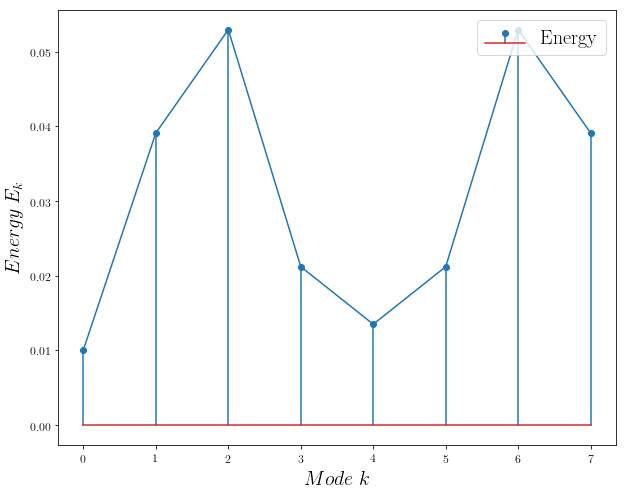

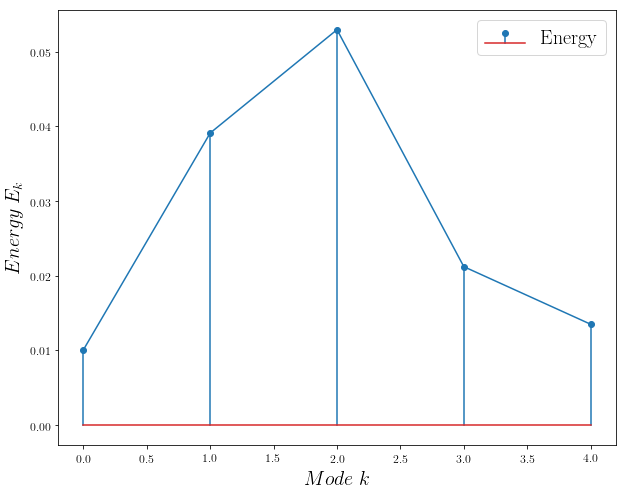

In [220]:
# Average Xk                                                                                          
Xk_avg = np.mean(Xk,0)

# Energy spectrum  (using the equation below Equation 4.4 defining Ek)                                                                                 
Xkc = Xk-matlib.repmat(Xk_avg,N_train,1);
Ek = np.real(np.mean(np.multiply(Xkc,np.conj(Xkc)),0));
print(Ek.shape)

# Plotting the energy 

fig = plt.figure()
plt.stem(range(0,J), Ek,  label="Energy")
plt.plot(range(0,J), Ek)
plt.xlabel("$Mode \; k$", fontsize=20)
plt.ylabel("$Energy \; E_k$", fontsize=20)
plt.legend(loc="upper right", fontsize=20)        
plt.show()                                                                                        

# only half the coefficients needed
fig = plt.figure()
plt.stem(range(0,int(J/2)+1), Ek[0:int(J/2)+1],  label="Energy")
plt.plot(range(0,int(J/2)+1), Ek[0:int(J/2)+1])
plt.xlabel("$Mode \; k$", fontsize=20)
plt.ylabel("$Energy \; E_k$", fontsize=20)
plt.legend(loc="upper right", fontsize=20)        
plt.show()                                                                                        

[2 1 3 4 0]


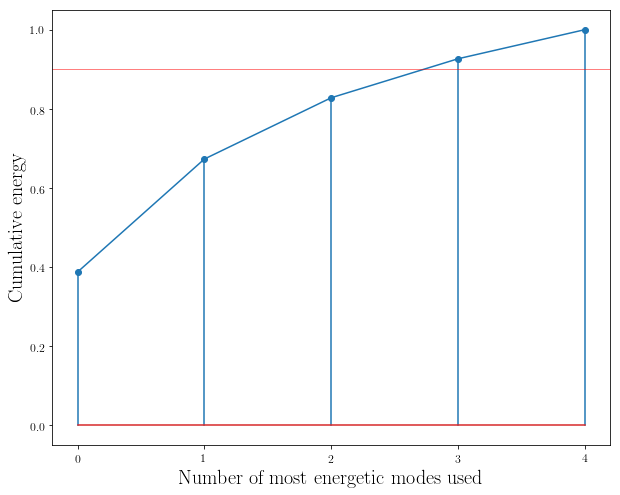

In [217]:
# plotting number of modes used against cumulative energy %

idx = np.argsort(-Ek[0:int(J/2)+1])
print(idx)
sEk = Ek[idx]
cEk = np.cumsum(sEk/np.sum(sEk))
fig = plt.figure()
plt.stem(range(0,int(J/2)+1), cEk)
plt.plot(range(0,int(J/2)+1), cEk)
plt.axhline(y=0.9,linewidth=0.5,color='r')
plt.xlabel("Number of most energetic modes used", fontsize=20)
plt.xticks(range(int(J/2)+1))
plt.ylabel("Cumulative energy %", fontsize=20)
#plt.legend(loc="upper right", fontsize=20)        
plt.show()   

## Find the most energetic modes
- not needed for our analysis, but done for completeness

In [218]:
# Get the most energetic modes                                                                      
rdim = int(J/2) + 1

idx = np.argsort(-Ek[0:int(J/2)+1])
idx = np.array(idx[0:rdim])
Ekr = Ek[idx]
print("Most energetic modes computed: ", idx)
print("Most energetic modes used: ", idx)
print("Energies: ", Ekr)

Most energetic modes computed:  [2 1 3 4 0]
Most energetic modes used:  [2 1 3 4 0]
Energies:  [0.05292516 0.03909186 0.02120044 0.01349136 0.01006354]


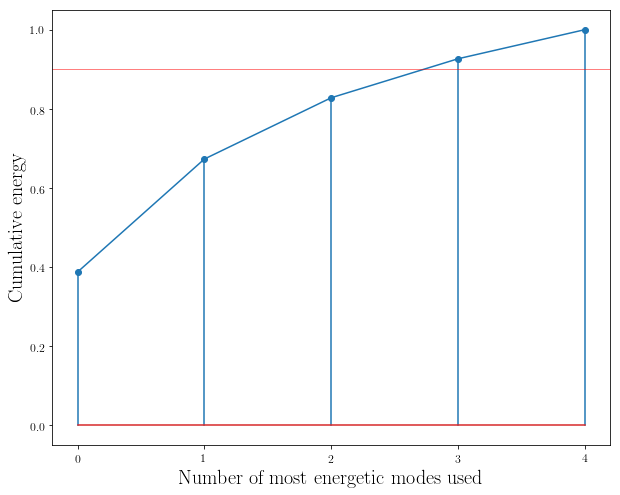

In [219]:
# plotting number of modes used against cumulative energy %
 
cEkr = np.cumsum(Ekr/np.sum(Ekr))
fig = plt.figure()
plt.stem(range(0,int(J/2)+1), cEkr)
plt.plot(range(0,int(J/2)+1), cEkr)
plt.axhline(y=0.9,linewidth=0.5,color='r')
plt.xlabel("Number of most energetic modes used", fontsize=20)
plt.xticks(range(Ekr.shape[0]))
plt.ylabel("Cumulative energy %", fontsize=20)
#plt.legend(loc="upper right", fontsize=20)        
plt.show()   

## Computing reduced order Fourier modes

In [181]:
# reduced order Fourier modes 
print(Xk.shape)
dXkdt = np.matrix(np.zeros(Xk.shape), dtype=np.complex)
end = dXkdt.shape[0]

# compute dXk/dt by finite differencing
dXkdt[1:end-1,:] = (Xk[2:end,:]-Xk[0:end-2,:])/(2.*dt)
dXkdt[0,:] = (Xk[1,:]-Xk[0,:])/dt
dXkdt[end-1,:] = (Xk[end-1,:]-Xk[end-2,:])/dt

# pull out reduced modes for Xk and dXkdt (Xkr and dXkdtr)
Xkr = Xk[:,idx]
Xkr_re = np.real(Xkr)
Xkr_im = np.imag(Xkr)

dXkrdt = dXkdt[:,idx]
dXkrdt_re = np.real(dXkrdt)
dXkrdt_im = np.imag(dXkrdt)

(500000, 8)


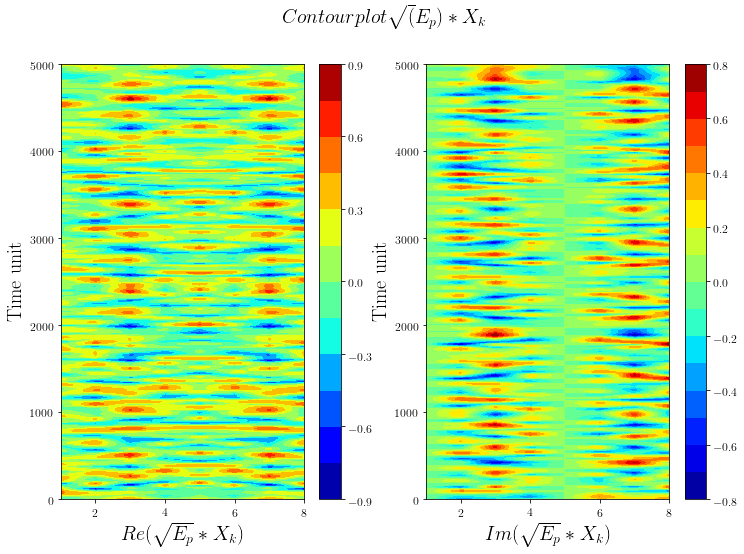

In [188]:
# Plotting the contour plot of the fourier modes (only 5000 initial estimates)                      
fig = plt.figure(figsize=(12.0, 8.0))
fig.suptitle("$Contour \; plot \sqrt(E_p) * X_{k}$", fontsize=20)
s, t = np.meshgrid(np.array(range(J))+1, np.array(range(np.min([5000,Xk.shape[0]])))+1)
plt.subplot(121)
plt.contourf(s, t, np.sqrt(Ep)*np.real(Xk[0:5000,:]), 15, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("$Re(\sqrt{E_p} * X_{k}$)", fontsize=20)
plt.ylabel("Time unit", fontsize=20)
plt.subplot(122)
plt.contourf(s, t, np.sqrt(Ep)*np.imag(Xk[0:5000,:]), 15, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("$Im(\sqrt{E_p} * X_{k}$)", fontsize=20)
plt.ylabel("Time unit", fontsize=20);

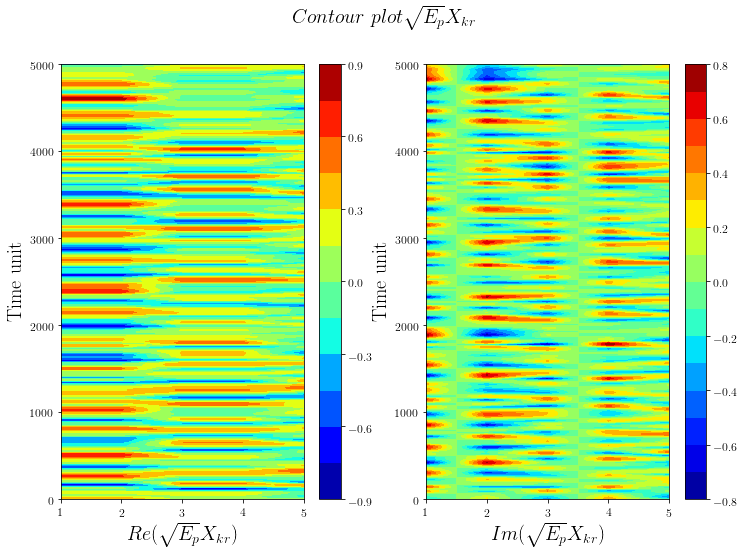

In [192]:
# Plotting the contour plot of the reduced fourier modes (only 5000 initial estimates)              
fig = plt.figure(figsize=(12.0, 8.0))
fig.suptitle("$Contour \; plot \sqrt{E_p} X_{kr}$", fontsize=20)
s, t = np.meshgrid(np.array(range(rdim))+1, np.array(range(np.min([5000,Xkr_im.shape[0]])))+1)
plt.subplot(121)
plt.contourf(s, t, np.sqrt(Ep)*Xkr_re[0:5000,:], 15, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("$Re(\sqrt{E_p} X_{kr})$", fontsize=20)
plt.ylabel("Time unit", fontsize=20)
plt.subplot(122)
plt.contourf(s, t, np.sqrt(Ep)*Xkr_im[0:5000,:], 15, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("$Im(\sqrt{E_p} X_{kr})$", fontsize=20)
plt.ylabel("Time unit", fontsize=20);     

## Repeat all the computation for X_test

In [224]:

#X_bar = X_test.mean()
time_vector = np.transpose(np.matrix(range(1,N_test+1)))*dt

Ep = np.sum(np.trapz(np.power(X_test-X_bar,2), time_vector, axis=0))/(2.*T)
print("Variance in energy flunctuations {:f}".format(Ep))

# normalization step
    
Xj = (X_test-X_bar)/np.sqrt(Ep)
Xj_bar = np.mean(Xj)
dtp = np.sqrt(Ep)*dt

Ep_norm = np.sum(np.trapz(np.power(Xj-Xj_bar,2), time_vector, axis=0))/(2.*T)
print("Normalized average variance in energy flunctuations (MUST BE ONE): {:f}".format(Ep_norm))
print(Ep_norm)

# Discrete Fourier Coefficients                                                                     
Xk = np.fft.fft(Xj, J, 1)/J

# FFT test                                                                                          
Xj_rec = np.real(J*np.fft.ifft(Xk, J, 1));
print("Fourier transformation reconstruction error (MUST BE ZERO):  {:f}".format(np.linalg.norm(Xj-\
Xj_rec)))
print(Xk.shape)

Variance in energy flunctuations 0.008628
Normalized average variance in energy flunctuations (MUST BE ONE): 0.996253
0.9962526666441297
Fourier transformation reconstruction error (MUST BE ZERO):  0.000000
(1000, 8)


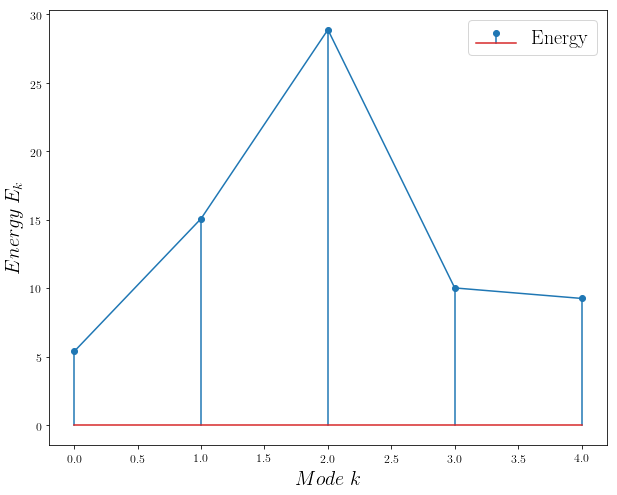

In [225]:
# Average                                                                                           
Xk_avg = np.mean(Xk,0)

# Energy spectrum                                                                                   
Xkc = Xk-matlib.repmat(Xk_avg,N_test,1);
Ek = np.real(np.mean(np.multiply(Xkc,np.conj(Xkc)),0));

# Plotting the energy  
fig = plt.figure()
plt.stem(range(0,int(J/2)+1), Ek[:int(J/2)+1],  label="Energy")
plt.plot(range(0,int(J/2)+1), Ek[:int(J/2)+1])
plt.xlabel("$Mode \; k$", fontsize=20)
plt.ylabel("$Energy \; E_k$", fontsize=20)
plt.legend(loc="upper right", fontsize=20)        
plt.show()                                                                                         

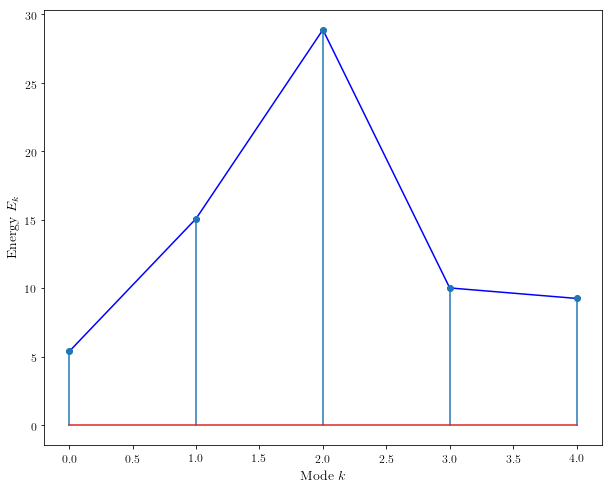

In [227]:
# Plotting the energy                                                                                    
fig = plt.figure()                                                                                       
plt.rc("text", usetex=True)                                                                              
plt.rc("font", family="serif")                                                                           
                                                                                      
plt.plot(range(0,int(J/2)+1), Ek[0:int(J/2)+1], "-*b")                                                                           
plt.stem(range(0,int(J/2)+1), Ek[0:int(J/2)+1])                          

# plt.xticks(np.linspace(0,20,21))                                                                         
plt.xlabel(r"Mode $k$", fontsize=14)                                                               
plt.ylabel(r"Energy $E_k$", fontsize=14);                                                                
#plt.legend(loc="upper right", fontsize=14)                                                                                                                                               

In [228]:
# Get the most energetic modes                                                                      
rdim = int(J/2)+1

idx = np.argsort(-Ek[0:int(J/2)+1])
idx = np.array(idx[0:rdim])
Ekr = Ek[idx]
print("Most energetic modes computed: ", idx)
print("Most energetic modes used: ", idx)
print("Energies: ", Ekr)

Most energetic modes computed:  [2 1 3 4 0]
Most energetic modes used:  [2 1 3 4 0]
Energies:  [28.887791   15.08314454 10.01814217  9.25116156  5.38132535]


In [199]:
# reduced order Fourier modes

dXkdt = np.matrix(np.zeros(Xk.shape), dtype=np.complex)
end = dXkdt.shape[0]
dXkdt[1:end-1,:] = (Xk[2:end,:]-Xk[0:end-2,:])/(2.*dt)
dXkdt[0,:] = (Xk[1,:]-Xk[0,:])/dt
dXkdt[end-1,:] = (Xk[end-1,:]-Xk[end-2,:])/dt

In [200]:
Xkr = Xk[:,idx]
Xkr_re = np.real(Xkr)
Xkr_im = np.imag(Xkr)

dXkrdt = dXkdt[:,idx]
dXkrdt_re = np.real(dXkrdt)
dXkrdt_im = np.imag(dXkrdt)

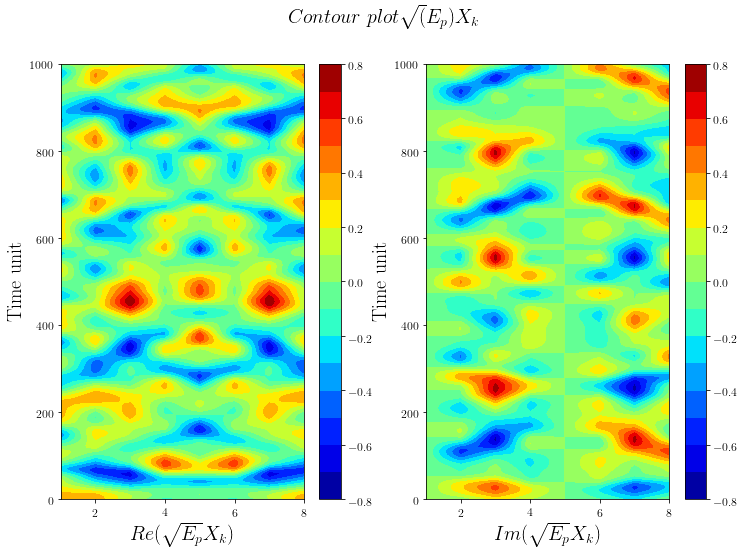

In [201]:
# Plotting the contour plot of the fourier modes (only 5000 initial estimates)                      
fig = plt.figure(figsize=(12.0, 8.0))
fig.suptitle("$Contour \; plot \sqrt(E_p) X_{k}$", fontsize=20)
s, t = np.meshgrid(np.array(range(J))+1, np.array(range(np.min([5000,Xk.shape[0]])))+1)
plt.subplot(121)
plt.contourf(s, t, np.sqrt(Ep)*np.real(Xk[0:5000,:]), 15, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("$Re(\sqrt{E_p} X_{k})$", fontsize=20)
plt.ylabel("Time unit", fontsize=20)
plt.subplot(122)
plt.contourf(s, t, np.sqrt(Ep)*np.imag(Xk[0:5000,:]), 15, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("$Im(\sqrt{E_p} X_{k})$", fontsize=20)
plt.ylabel("Time unit", fontsize=20);


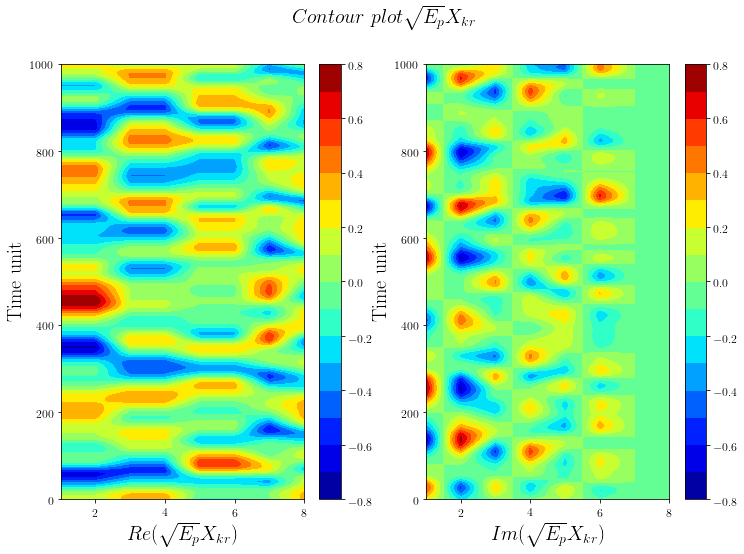

In [202]:
# Plotting the contour plot of the reduced fourier modes (only 5000 initial estimates)              
fig = plt.figure(figsize=(12.0, 8.0))
fig.suptitle("$Contour \;plot \sqrt{E_p} X_{kr}$", fontsize=20)
s, t = np.meshgrid(np.array(range(rdim))+1, np.array(range(np.min([5000,Xkr_im.shape[0]])))+1)
plt.subplot(121)
plt.contourf(s, t, np.sqrt(Ep)*Xkr_re[0:5000,:], 15, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("$Re(\sqrt{E_p} X_{kr})$", fontsize=20)
plt.ylabel("Time unit", fontsize=20)
plt.subplot(122)
plt.contourf(s, t, np.sqrt(Ep)*Xkr_im[0:5000,:], 15, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("$Im(\sqrt{E_p} X_{kr})$", fontsize=20)
plt.ylabel("Time unit", fontsize=20);       

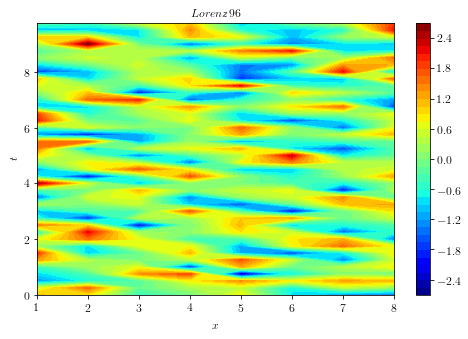

In [229]:
dt = 0.005
step = 50
N_plot = 2000

X = vals[N_transients:N_transients+N_train,:]
X = X[:N_plot,:][::step,:]
N_plot = X.shape[0]

color_map = 'jet' # 'cool'                                                                             
fontsize = 12
plt.rcParams.update({'font.size': fontsize})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 5))
ax.set_title(r"$Lorenz96$", fontsize=fontsize)
s, t = np.meshgrid(np.array(range(J))+1, dt*step*np.array(range(N_plot)))
map1 = ax.contourf(s, t, X[:N_plot,:], 35, cmap=plt.get_cmap(color_map))
ax.set_xlabel(r"$x$", fontsize=fontsize)
ax.set_xlim(1,J)
#ax.set_xticks([10,20,40],[10,20,40])
#ax.set_yticks([0,5,10,15,20],[0,5,10,15,20])
ax.set_ylabel(r"$t$", fontsize=fontsize);
plt.colorbar(map1)

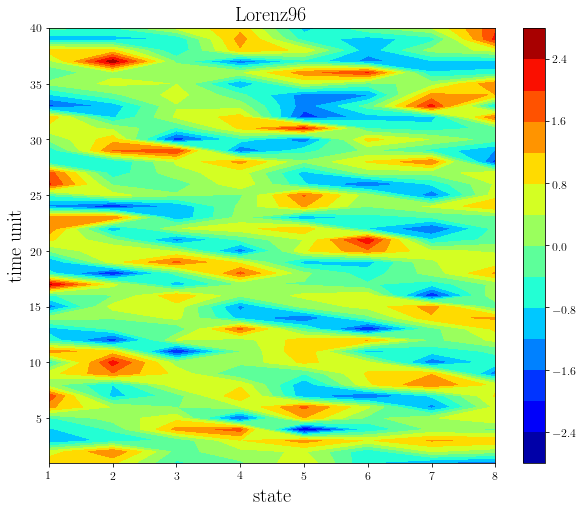

In [205]:
fig = plt.figure()
s,t = np.meshgrid(np.array(range(8))+1,np.array(range(np.min([10000,X.shape[0]])))+1)
plt.contourf(s,t,X[0:10000,:],15,cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel("state", fontsize=20)
plt.ylabel("time unit",fontsize=20)
plt.title("Lorenz96",fontsize=20)
plt.show()

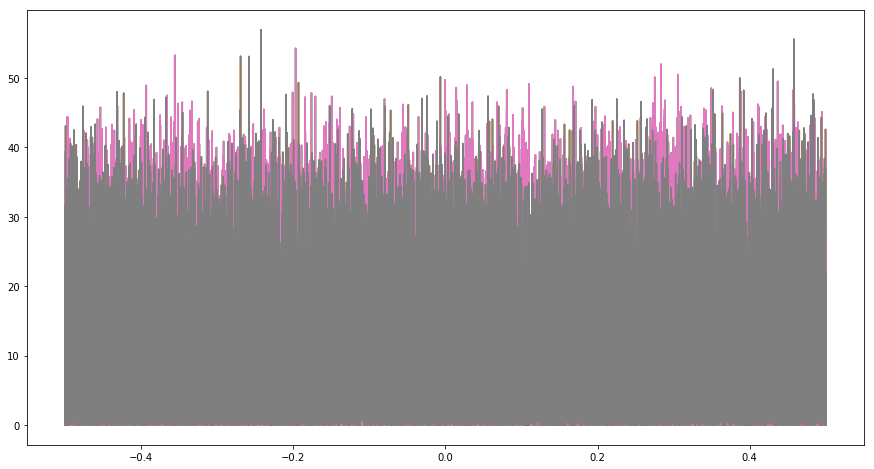

In [18]:
# Discrete Fourier Transform
ft = np.fft.fft(L96)
freq = np.fft.fftfreq(L96.shape[0])
plt.plot(freq, ft.real**2 + ft.imag**2)

(-100.0, 100.0)

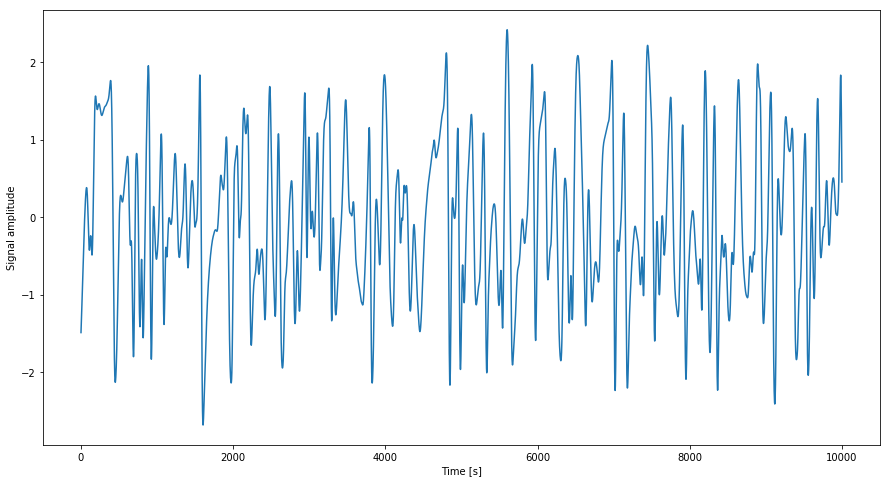

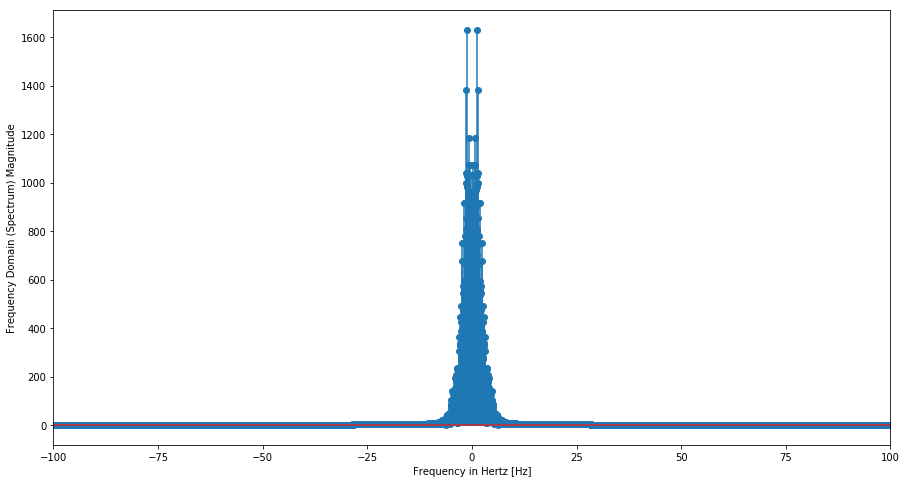

In [14]:
from scipy import fftpack
  
f_s = 200  # Sampling rate, or number of measurements per second

x = L96.x8.values[:10000]

fig, ax = plt.subplots()
ax.plot(x)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal amplitude');

X = fftpack.fft(x)
freqs = fftpack.fftfreq(len(x)) * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(X))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
#ax.set_ylim(-5, 110)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: stem() got an unexpected keyword argument 'linewidth'. This will raise a TypeError in future versions.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.


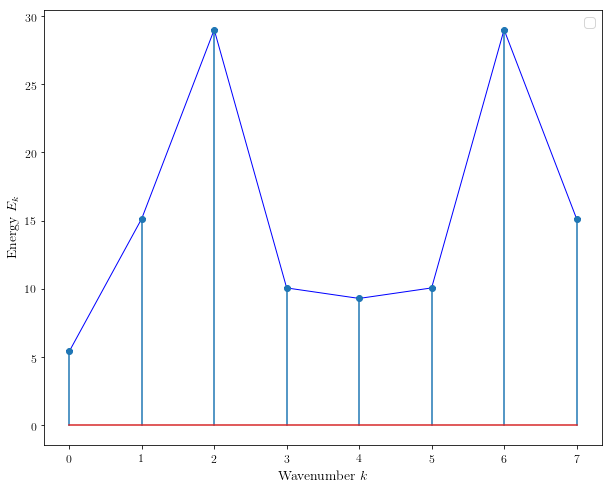